### The PyTorch Dataset for the RT-DETR model ###

In [227]:
import os
import numpy as np
import pandas as pd
import logging
import glob
import datetime
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import patches

# PyTorch framework
import torch

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.detrdataset import get_gpu_info, DetectionDatasetFromDF
from detection.detransform import DetrTransform
from detection.imageproc import clipxywh, ImageData

print(f'Project module version: {dt.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev26+g0781d45


In [21]:
# Set device
device, device_str = get_gpu_info()

# Save the date in a string
date_str = datetime.date.today().strftime('%y%m%d')
print(f'Date: {date_str}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.6.0a0+ecf3bae40a.nv25.01
CUDA version:      12.8
CUDNN version:     90700
Date: 250224


### Helpfer functions for this notebook ###

In [123]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

### Locations for the data ###

In [16]:
# Data directory
data_root = os.path.join(os.environ.get('HOME'), 'data')
data_dir = os.path.join(data_root, 'dentex_detection')

# Save model checkpoints
model_dir = os.path.join(data_dir, 'model')
Path(model_dir).mkdir(exist_ok=True, parents=True)

# Log files
log_dir = os.path.join(model_dir, 'log')
Path(log_dir).mkdir(exist_ok=True, parents=True)

# Image directory (after cropping the data)
image_dir = os.path.join(data_dir, 'quadrants')

# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 2531
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Found {len(file_list)} images.')

Found 2531 images.


### Load the annotations ###

In [25]:
annotation_file_name = 'train_split_250224.parquet'
annotation_file = os.path.join(image_dir, annotation_file_name)
df = pd.read_parquet(annotation_file)

# Create the label column (the tooth position, but starting from 0)
label_name_list = sorted(list(df['ada'].unique()))
id2label = dict(zip(range(len(label_name_list)), label_name_list))
label2id = {name: label for label, name in id2label.items()}

# Add columns with the file paths and the labels
df = df.assign(file=df['file_name'].apply(lambda f: os.path.join(image_dir, f)),
               label=df['ada'].apply(lambda i: label2id.get(i)))
display(df.head())
print(sorted(list(df['label'].unique())))

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset,file,label
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8,train,/app/data/dentex_detection/quadrants/train_0_1...,7
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7,train,/app/data/dentex_detection/quadrants/train_0_1...,6
2,train_0_1.png,1,3,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",13,6,train,/app/data/dentex_detection/quadrants/train_0_1...,5
3,train_0_1.png,1,4,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",14,5,train,/app/data/dentex_detection/quadrants/train_0_1...,4
4,train_0_1.png,1,5,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",15,4,train,/app/data/dentex_detection/quadrants/train_0_1...,3


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


### Set up logging ###

In [23]:
log_file_name = f'train_log_{date_str}.log'
log_file = os.path.join(log_dir, log_file_name)
print(log_file)

/app/data/dentex_detection/model/log/train_log_250224.log


In [24]:
dtfmt = '%y%m%d-%H:%M'
logfmt = '%(asctime)s-%(name)s-%(levelname)s-%(message)s'
logging.basicConfig(filename=log_file,
                    filemode='w',
                    level=logging.INFO,
                    format=logfmt,
                    datefmt=dtfmt)
logger = logging.getLogger(name=__name__)

### Create the data sets ###

In [79]:
# Augmentations
use_transform = 'transform_1'
train_transform = DetrTransform(use_transform).train_transform()
val_transform = DetrTransform(use_transform).val_transform()

# Image preprocessing
hf_checkpoint = 'PekingU/rtdetr_v2_r101vd'
image_processor = RTDetrImageProcessor.from_pretrained(hf_checkpoint)

# Create the data sets
dset_list = sorted(list(df['dset'].unique()))
print(dset_list)
dataset_dict = {}
for dset in dset_list:
    df_dset = df.loc[df['dset'] == dset]
    if dset == 'train':
        transform = train_transform
    else:
        transform = val_transform
    dataset = DetectionDatasetFromDF(data=df_dset, 
                                     processor=image_processor, 
                                     file_col='file', 
                                     label_col='label', 
                                     bbox_col='bbox', 
                                     transform=transform, 
                                     bbox_format='xywh', 
                                     validate=True)
    dataset_dict.update({dset: dataset})
    print(f'Number of images in {dset.upper()}: {len(dataset)}')

['test', 'train', 'val']
Number of images in TEST: 32
Number of images in TRAIN: 2479
Number of images in VAL: 20


### Verify the output of the data set ###

In [269]:
def yolo2xywh(yolobox, width, height):
    """ 
    YOLO bounding box format is [x_center, y_center, width, height] 
    in normalized coordinates 
    """
    try:
        assert isinstance(yolobox, (list, tuple, np.ndarray)) and len(yolobox)==4
    except:
        raise AssertionError('yolobox is a bounding box in yolo format!')
    else:
        x_rel, y_rel, w_rel, h_rel = yolobox
        xywh = [(x_rel-(w_rel/2)) * width, 
                (y_rel-(h_rel/2)) * height, 
                w_rel * width, h_rel * height]
    return xywh

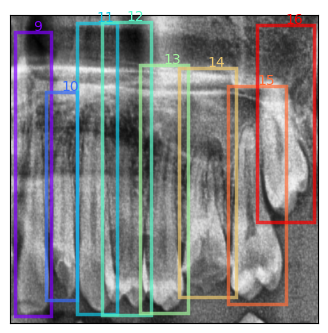

In [271]:
idx = 10
dset = 'test'

# Check the output of the dataset for one image
dataset = dataset_dict.get(dset)
ds = dataset[idx]

# IMAGE
ds_im = ds['pixel_values']
im = ds_im.permute(1, 2, 0).numpy()

# BOUNDING BOXES AND ANNOTATIONS
im_size = 640
xlim, ylim = (0, im_size), (0, im_size)
label_list = list(ds['labels']['class_labels'].numpy())
pos_list = [id2label.get(l) for l in label_list] 
bbox_list = list(ds['labels']['boxes'].numpy())
box_list = [yolo2xywh(box, width=im.shape[1], height=im.shape[0]) for box in bbox_list]

# Plot the image
fig, ax = plt.subplots(figsize=(6, 4))
ax = show_image_with_boxes(image=im, box_list=box_list, label_list=pos_list, ax=ax)
plt.show()

/app/data/dentex_detection/quadrants/train_344_2.png


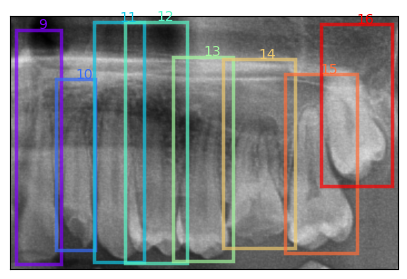

In [273]:
# Get the original image
file_name = df.loc[df['dset'] == dset, 'file_name'].unique()[idx]
df_file = df.loc[df['file_name'] == file_name]
file = os.path.join(image_dir, file_name)
print(file)
im = ImageData().load_image(file)


box_list = df_file['bbox'].tolist()
pos_list = df_file['ada'].tolist()

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=False)
ax = show_image_with_boxes(image=im, box_list=box_list, label_list=pos_list, ax=ax)
plt.show()